<a href="https://colab.research.google.com/github/rickituri98/Fault_Classifier_CNN/blob/master/Data_Handling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Handling - Fault Events from IEEE 13 Node Test Feeder

## Files import from GitHub Repository

In [1]:
!npx degit rickituri98/Fault_Classifier_CNN -f

npx: installed 1 in 2.595s
> destination directory is not empty. Using --force, continuing
> cloned rickituri98/Fault_Classifier_CNN#master


Modules import and functions initialization

In [2]:
import os
import copy
import sys
from comtrade import Comtrade
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import interactive
import time
import pandas as pd
import seaborn as sns
import scipy.io as sio
from IPython.display import display
import pywt
import scipy.stats
import pickle
import datetime as dt
from collections import defaultdict, Counter
from scipy.signal import find_peaks
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

path_NOGD = '/content/Events_Comtrade/Faults_Recorders_NO_GD_SubTrafo/'
path_GD = '/content/Events_Comtrade/Faults_Recorders_CON_GD/'

with open('/content/Events_Comtrade/Comtrade_ids_dict.pickle', 'rb') as handle:
    Comtrade_ids = pickle.load(handle)
Total_id_files = Comtrade_ids.get('id_names')

def import_files(path):
  dir_list = sorted(os.listdir(path)) # lista de señales en comtrade
  tupfiles = list() # lista de pares de archivos cfg y dat
  l = np.arange(0, len(dir_list), 2)
  recorders = list()
  for i in l:
    (cfg, dat) = (dir_list[i], dir_list[i+1])
    tupfiles.append((cfg, dat))
    record = Comtrade()
    recorders.append(record)
  return tupfiles, recorders

def creacion_dic(dic,valores,string):
  pos = string.find("/")
  if string[pos-1]=='A':
    dic['A']= np.array(valores)
  if string[pos-1]=='B':
    dic['B']= np.array(valores)
  if string[pos-1]=='C':
    dic['C']= np.array(valores)

def get_XY(path,tupfile, record):
  record.load(path+tupfile[0])
  num_sig = record.analog_count
  timesec = np.array(record.time)
  samples =record.total_samples
  dic1=dict.fromkeys(['A','B','C'],np.zeros(samples))
  dic1['time']=timesec
  dic2=dict.fromkeys(['A','B','C'],np.zeros(samples))
  dic2['time']=timesec
  dic3=dict.fromkeys(['A','B','C'],np.zeros(samples))
  dic3['time']=timesec
  dic4=dict.fromkeys(['A','B','C'],np.zeros(samples))
  dic4['time']=timesec
  for k in range(0, num_sig):
    string = record.analog_channel_ids[k]
    if string.startswith('LC684-652A'):
      creacion_dic(dic1,record.analog[k],string)
    elif string.startswith('LC692-675'):
      creacion_dic(dic2,record.analog[k],string)
    elif string.startswith('LOHL632-633'):
      creacion_dic(dic3,record.analog[k],string)
    elif string.startswith('LOHL645-646'):
      creacion_dic(dic4,record.analog[k],string)
  list_dic=[dic1,dic2,dic3,dic4]
  return list_dic

def fill_Siglist(lista, sublista):
  lista.append(sublista[0])
  lista.append(sublista[1])
  lista.append(sublista[2])
  lista.append(sublista[3])

def Inputs_Vectors(path, tupfiles, recorders):
  signal_list = list()
  Fault_type_list = list()
  Fault_cat_list = list()
  
  ph_1, ph_2, ph_2G, ph_3, noF = 0, 1, 2, 3, 4
  for entry in range(len(tupfiles)):
    sub_typeF = list()
    cat_F = list()
    list_sig = get_XY(path,tupfiles[entry], recorders[entry])
    id_f = tupfiles[entry][0]
    
    if id_f.find("_L692-675_") != -1 or id_f.find("_L632-633_") != -1 or id_f.find("_L671-680_") != -1:
      
      if id_f.find("Falla_A_") != -1:
        fill_Siglist(signal_list, list_sig)
        sub_typeF.append(np.array([[1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 1]]))
        cat_F.append([ph_1, ph_1, ph_1, noF])
      elif id_f.find("Falla_B_") != -1:
        fill_Siglist(signal_list, list_sig)
        sub_typeF.append(np.array([[0, 0, 0, 0, 1], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0]]))
        cat_F.append([noF, ph_1, ph_1, ph_1])
      elif id_f.find("Falla_C_") != -1:
        fill_Siglist(signal_list, list_sig)
        sub_typeF.append(np.array([[1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0]]))
        cat_F.append([ph_1, ph_1, ph_1, ph_1])
      elif id_f.find("Falla_2F_") != -1:
        if id_f.find("_CA_") != -1:
          fill_Siglist(signal_list, list_sig)
          sub_typeF.append(np.array([[0, 1, 0, 0, 0], [0, 1, 0, 0, 0], [0, 1, 0, 0, 0], [1, 0, 0, 0, 0]]))
          cat_F.append([ph_2, ph_2, ph_2, ph_1])
        elif id_f.find("_BC_") != -1:
          fill_Siglist(signal_list, list_sig)
          sub_typeF.append(np.array([[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 1, 0, 0, 0], [0, 1, 0, 0, 0]]))
          cat_F.append([ph_1, ph_2, ph_2, ph_2])
        elif id_f.find("_AB_") != -1:
          fill_Siglist(signal_list, list_sig)
          sub_typeF.append(np.array([[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 1, 0, 0, 0], [1, 0, 0, 0, 0]]))
          cat_F.append([ph_1, ph_2, ph_2, ph_1])  
      elif id_f.find("Falla_2GF_") != -1:
        if id_f.find("_CA_") != -1:
          fill_Siglist(signal_list, list_sig)
          sub_typeF.append(np.array([[0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [1, 0, 0, 0, 0]]))
          cat_F.append([ph_2G, ph_2G, ph_2G, ph_1])
        elif id_f.find("_BC_") != -1:
          fill_Siglist(signal_list, list_sig)
          sub_typeF.append(np.array([[1, 0, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0]]))
          cat_F.append([ph_1, ph_2G, ph_2G, ph_2G])
        elif id_f.find("_AB_") != -1:
          fill_Siglist(signal_list, list_sig)
          sub_typeF.append(np.array([[1, 0, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [1, 0, 0, 0, 0]]))
          cat_F.append([ph_1, ph_2G, ph_2G, ph_1])        
      elif id_f.find("Falla_3F_") != -1:
        fill_Siglist(signal_list, list_sig)
        sub_typeF.append(np.array([[0, 0, 1, 0, 0],[0, 0, 0, 1, 0], [0, 0, 0, 1, 0], [0, 0, 1, 0, 0]]))
        cat_F.append([ph_2G, ph_3, ph_3, ph_2G])
    
    elif id_f.find("_L684-652_") != -1:
      fill_Siglist(signal_list, list_sig)
      sub_typeF.append(np.array([[1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 1]]))
      cat_F.append([ph_1, ph_1, ph_1, noF])

    else:
      fill_Siglist(signal_list, list_sig)
      sub_typeF.append(np.array([[1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0]]))
      cat_F.append([ph_1, ph_1, ph_1, ph_1])      
    
    Fault_type_list.append(sub_typeF)
    Fault_cat_list.append(cat_F)
  s1 = np.array(Fault_type_list).shape
  s2 = np.array(Fault_cat_list).shape
  Fault_type_list = np.array(Fault_type_list).reshape((s1[0]*s1[2], s1[3]))
  Fault_cat_list = np.array(Fault_cat_list).reshape((s2[0]*s2[2], s2[1])) 
  return signal_list, Fault_type_list, Fault_cat_list 

tupfiles_NOGD, recorders_NOGD = import_files(path_NOGD)
tupfiles_GD, recorders_GD, = import_files(path_GD)
signals_NOGD, fault_type_NOGD, f_catNOGD = Inputs_Vectors(path_NOGD, tupfiles_NOGD, recorders_NOGD)
signals_GD, fault_type_GD, f_catGD = Inputs_Vectors(path_GD,tupfiles_GD, recorders_GD)

print(len(signals_NOGD), len(signals_GD), f_catNOGD.shape,  f_catGD.shape)


/content/comtrade.py:298: Warning: Unknown standard revision "2000"
  warnings.warn(Warning(msg))


336 336 (336, 1) (336, 1)
[('Oscilografías_L632-633_Falla_2F_BC_10%_SubTNOGD.cfg', 'Oscilografías_L632-633_Falla_2F_BC_10%_SubTNOGD.dat'), ('Oscilografías_L632-633_Falla_2F_BC_30%_SubTNOGD.cfg', 'Oscilografías_L632-633_Falla_2F_BC_30%_SubTNOGD.dat'), ('Oscilografías_L632-633_Falla_2F_BC_50%_SubTNOGD.cfg', 'Oscilografías_L632-633_Falla_2F_BC_50%_SubTNOGD.dat'), ('Oscilografías_L632-633_Falla_2F_BC_70%_SubTNOGD.cfg', 'Oscilografías_L632-633_Falla_2F_BC_70%_SubTNOGD.dat'), ('Oscilografías_L632-633_Falla_2GF_CA_10%_SubTNOGD.cfg', 'Oscilografías_L632-633_Falla_2GF_CA_10%_SubTNOGD.dat'), ('Oscilografías_L632-633_Falla_2GF_CA_30%_SubTNOGD.cfg', 'Oscilografías_L632-633_Falla_2GF_CA_30%_SubTNOGD.dat'), ('Oscilografías_L632-633_Falla_2GF_CA_50%_SubTNOGD.cfg', 'Oscilografías_L632-633_Falla_2GF_CA_50%_SubTNOGD.dat'), ('Oscilografías_L632-633_Falla_2GF_CA_70%_SubTNOGD.cfg', 'Oscilografías_L632-633_Falla_2GF_CA_70%_SubTNOGD.dat'), ('Oscilografías_L632-633_Falla_3F_10%_SubTNOGD.cfg', 'Oscilografías_L

In [3]:
## UNIFICACIÓN GD y NOGD
Total_signals = np.concatenate((np.array(signals_NOGD), np.array(signals_GD)), axis = 0)
Total_faults_types = np.concatenate((fault_type_NOGD, fault_type_GD), axis = 0)
Total_faults_ids = np.concatenate((f_catNOGD, f_catGD), axis = 0)
print("# Total de eventos de falla:", Total_signals.shape[0])
print("# Dimensión del conjunto de eventos de falla etiquetados:",Total_faults_types.shape)

# Total de eventos de falla: 672
# Dimensión del conjunto de eventos de falla etiquetados: (672, 5)


In [4]:
def time_event(peaks, ind, t_start, t_end, dur, tsec, n):  
  if t_start == 0 and t_end == 0:
    t_start = peaks[ind-1]
    t_end = 1
  else:
    t_end = peaks[ind]
    dur = tsec[-1]*(t_end-t_start)/n
  return t_start, t_end, dur

def sag_detector(cApprox,peaks,Vpre_sag,t_start,t_end,dur,mag, tsec):
  haha=False
  for ind in range(1,len(peaks)-1):
      
      if (cApprox[peaks[ind]]/Vpre_sag) < 0.9: 
        mag = np.min(cApprox[peaks[1:len(peaks)-1]]/Vpre_sag)
        t_start, t_end, dur = time_event(peaks, ind, t_start, t_end, dur, tsec, len(cApprox))
        if haha==False:
          #print('Primero')
          haha=True   
  return dur,mag

def swell_detector(cApprox,peaks,Vpre_swell,t_start,t_end,dur,mag, tsec):
  entro=False
  for ind in range(1,len(peaks)-1):
      
      if (cApprox[peaks[ind]]/Vpre_swell) > 1.1: 
        t_start, t_end, dur = time_event(peaks, ind, t_start, t_end, dur, tsec, len(cApprox))
        mag=np.max(cApprox[peaks[ind]])/Vpre_swell
        if entro==False:
          #print('Segundo')
          entro=True
  return dur,mag

def event_result(cApprox, tsec):

  peaks, _ = find_peaks(cApprox, height = 0)
  
  ph_2 = np.max(cApprox)
  if ph_2 != 0:       
    Vpre_sag = np.max(cApprox[peaks[1:len(peaks)-1]])
    Vpre_swell = np.min(cApprox[peaks[1:len(peaks)-1]])
    #print('sag',Vpre_sag)
    duration1,magnitude1=sag_detector(cApprox,peaks,Vpre_sag,0,0,0,0, tsec)
    #print('swell',Vpre_swell)
    duration2,magnitude2=swell_detector(cApprox,peaks,Vpre_swell,0,0,0,0, tsec)
    #print('mag1',magnitude1,'dur1',duration1)
    #print('mag2',magnitude2,'dur2',duration2)
    if magnitude1<0.9 and duration1<=duration2:
      return duration1,magnitude1,True #Tipo Sag
    return duration2,magnitude2,False #Tipo Swell

  else:
    return 0, 0, False 



## Characterization of Lines by Location

In [5]:
def Location_groups(path, tupfiles, recorders):
  L1_list = list() # Eventos Linea 692-675 Bus 692
  L2_list = list() # Eventos Linea 632-633 Bus 632
  L3_list = list() # Eventos Linea 684-652 Bus 684
  L4_list = list() # Eventos Linea 645-646 Bus 645
  cat_fault = list()
  cat_fault3 = list()
  cat_fault4 = list()
  loc_orden = list() # orden de loc
  loc_orden2 = list() # orden de loc
  loc_orden3 = list() # orden de loc
  loc_orden4 = list() # orden de loc
  for entry in range(len(tupfiles)):
    sub_typeF = list()
    list_sig = get_XY(path,tupfiles[entry], recorders[entry])
    id_f = tupfiles[entry][0]    
    for loc in ['05', 10, 15, 20, 30, 35, 40, 45, 50, 60, 65, 70, 75, 80, 90, 95]:
      if id_f.find("Falla_A_") != -1:
        if id_f.find("_"+str(loc)+"%_")!=-1:
          L1_list.append(list_sig[1])
          L2_list.append(list_sig[2])
          L3_list.append(list_sig[0])
          loc_orden.append(int(loc))
          cat_fault.append(0)
          cat_fault3.append(0)
      elif id_f.find("Falla_C_") != -1:
        if id_f.find("_"+str(loc)+"%_")!=-1:
          L4_list.append(list_sig[-1])
          cat_fault4.append(0)   
          
      elif id_f.find("Falla_2F_") != -1:
        if id_f.find(str(loc)+"%_")!=-1:
          L1_list.append(list_sig[1])
          L2_list.append(list_sig[2])
          loc_orden2.append(int(loc))
          cat_fault.append(1)
      
      elif id_f.find("Falla_2GF_") != -1:
        if id_f.find(str(loc)+"%_")!=-1:
          L1_list.append(list_sig[1])
          L2_list.append(list_sig[2])
          loc_orden3.append(int(loc))
          cat_fault.append(2)
          
      elif id_f.find("Falla_3F_") != -1:
        if id_f.find(str(loc)+"%_")!=-1:
          L1_list.append(list_sig[1])
          L2_list.append(list_sig[2])
          L4_list.append(list_sig[-1])
          loc_orden4.append(int(loc))
          cat_fault.append(3)
          cat_fault4.append(2)
          
      
  return L1_list, L2_list, L3_list, L4_list, loc_orden, loc_orden2, loc_orden3, loc_orden4, cat_fault, cat_fault3, cat_fault4

l692, l632, l684, l645, locl, loc2, loc3, loc4, cat_f692, cat_f684, cat_f645 = Location_groups(path_NOGD, tupfiles_NOGD, recorders_NOGD)

print(len(locl), len(l692), len(l632), len(l684), len(l645))


/content/comtrade.py:298: Warning: Unknown standard revision "2000"
  warnings.warn(Warning(msg))


18 54 54 18 30


In [6]:
def Sag_curve(line, type_fault):
  ph_3_curve = []
  ph_2_curve = []
  ph_2g_curve = []
  ph_1_curve = []

  for ind in range(len(line)):
    phase_a = line[ind].get("A")
    phase_b = line[ind].get("B")
    phase_c = line[ind].get("C")
    timeset = line[ind].get("time")
    coeffs_a = pywt.wavedec(phase_a, 'bior4.4', level=5)
    coeffs_b = pywt.wavedec(phase_b, 'bior4.4', level=5)
    coeffs_c = pywt.wavedec(phase_c, 'bior4.4', level=5)
    dur_A, mag_A, type_event_A = event_result(coeffs_a[0], timeset)
    dur_B, mag_B, type_event_B = event_result(coeffs_b[0], timeset)
    dur_C, mag_C, type_event_C = event_result(coeffs_c[0], timeset)
    mag_pro = 0
    
    if type_fault[ind] == 0:
      
      if mag_A < 0.9 and dur_A != 0 and type_event_A == True and mag_A != 0:
        ph_1_curve.append(mag_A)
      elif mag_B < 0.9 and dur_B != 0 and type_event_B == True and mag_B != 0:
        ph_1_curve.append(mag_B)
      elif mag_C < 0.9 and dur_C != 0 and type_event_C == True and mag_C != 0:
        
        ph_1_curve.append(mag_C)
      
    elif type_fault[ind] == 1:
      if mag_A < 0.9 and dur_A != 0 and type_event_A == True and mag_A != 0:
        mag_pro= mag_A        
      if mag_B < 0.9 and dur_B != 0 and type_event_B == True and mag_B != 0:
        mag_pro= (mag_pro + mag_B)
      if mag_C < 0.9 and dur_C != 0 and type_event_C == True and mag_C != 0:
        mag_pro= (mag_pro + mag_C)
      
      ph_2_curve.append(mag_pro/2)
      
    
    elif type_fault[ind] == 2:
      if mag_A < 0.9 and dur_A != 0 and type_event_A == True and mag_A != 0:
        mag_pro= mag_A        
      if mag_B < 0.9 and dur_B != 0 and type_event_B == True and mag_B != 0:
        mag_pro= (mag_pro + mag_B)
      if mag_C < 0.9 and dur_C != 0 and type_event_C == True and mag_C != 0:
        mag_pro= (mag_pro + mag_C)
      
      ph_2g_curve.append(mag_pro/2)
      
    elif type_fault[ind] == 3:
      mag_pro = (mag_A+mag_B+mag_C)/3
      ph_3_curve.append(mag_pro)     
  return [np.array(ph_3_curve), np.array(ph_2_curve), np.array(ph_2g_curve), np.array(ph_1_curve)]

#curv3ph, curv2ph, curv2phg, curv1ph = Sag_curve(l692, locl, cat_f692)
L692_dotcurves = Sag_curve(l692, cat_f692)
L632_dotcurves = Sag_curve(l632, cat_f692)
L684_dotcurves = Sag_curve(l684, cat_f684)
L645_dotcurves = Sag_curve(l645, cat_f645)

print(type(L632_dotcurves[0]), len(L632_dotcurves[0]), len(L632_dotcurves[1]),len(L632_dotcurves[2]), len(L632_dotcurves[-1]))
#print(curv3ph[10],curv2ph[0], curv1ph[0])
#print(np.array(curv3ph).shape)
print(L692_dotcurves[0])
print(L645_dotcurves[1])


<class 'numpy.ndarray'> 12 12 12 18
[0.01370985 0.03358023 0.06645461 0.09160555 0.00488528 0.03390236
 0.08354453 0.11801364 0.01283079 0.01551385 0.02643948 0.05300729]
[]


In [7]:
def lin_Regression(location_vec, mag_vec):
  x = np.sort(np.array(location_vec)).reshape((len(location_vec),1))
  y = np.sort(mag_vec).reshape((len(mag_vec),1))

  # sckit-learn implementation

  # Model initialization
  regression_model = LinearRegression()
  # Fit the data(train the model)
  regression_model.fit(x, y)
  # Predict
  y_predicted = regression_model.predict(x)

  # model evaluation
  rmse = mean_squared_error(y, y_predicted)
  r2 = r2_score(y, y_predicted)

  ## printing values
  #print('Slope:' ,regression_model.coef_)
  #print('Intercept:', regression_model.intercept_)
  #print('Root mean squared error: ', rmse)
  #print('R2 score: ', r2)

  # plotting values

  # data points
  plt.scatter(x, y, s=10)
  plt.xlabel('% de la línea')
  plt.ylabel('magnitud del sag p.u')
  plt.grid()

  # predicted values
  plt.plot(x, y_predicted, color='r')
  plt.grid()
  plt.xlabel("% de la línea")
  plt.ylabel("magnitud del sag p.u")
  plt.show()
  return x,y_predicted


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

##Characteristic curve: Sag magnitude vs Distance (%) 

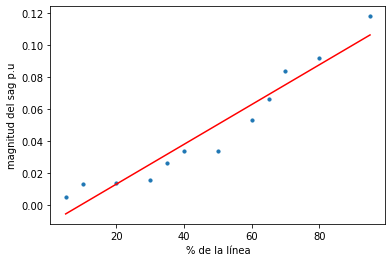

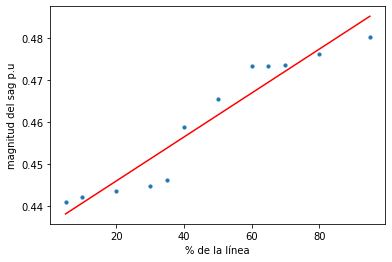

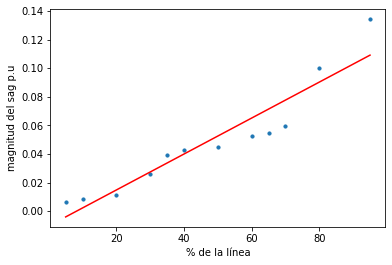

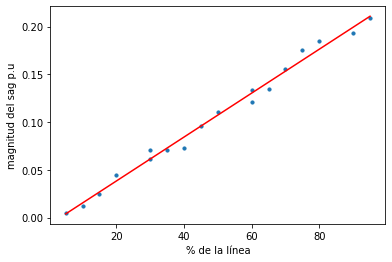

12 12 12 18


<function matplotlib.pyplot.show>

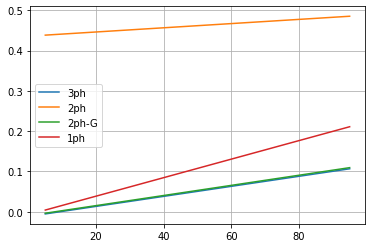

In [8]:
#print(y_predicted)
## Curvas para L692
loc3ph, mag3ph =lin_Regression(loc2, L692_dotcurves[0])
loc2ph, mag2ph =lin_Regression(loc2, L692_dotcurves[1])
loc2gph, mag2gph =lin_Regression(loc2, L692_dotcurves[2])
loc1ph, mag1ph =lin_Regression(locl, L692_dotcurves[-1])

Ch_curves_L692 = {"3-ph":[loc3ph, mag3ph],"2-ph":[loc2ph, mag2ph], "2-phG":[loc2gph, mag2gph], "1-ph":[loc1ph, mag1ph]}

print(len(mag3ph), len(mag2ph), len(mag2gph), len(mag1ph))
plt.figure()
plt.plot(loc3ph, mag3ph)
plt.plot(loc2ph, mag2ph)
plt.plot(loc2gph, mag2gph)
plt.plot(loc1ph, mag1ph)
plt.legend(['3ph', '2ph', '2ph-G', '1ph'])
plt.grid()
plt.show

#print(loc3ph[find_nearest(mag3ph, 0.25)])

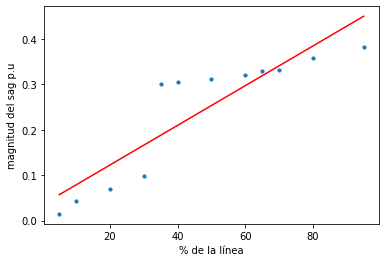

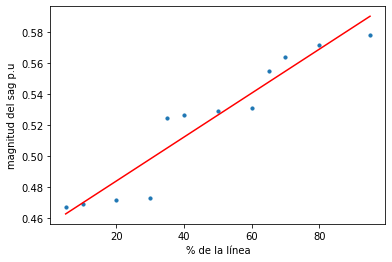

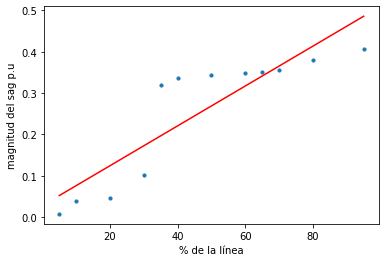

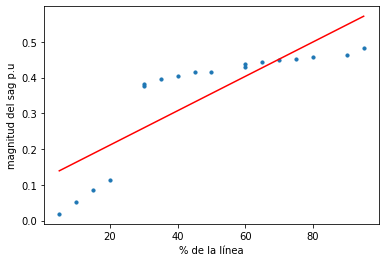

<function matplotlib.pyplot.show>

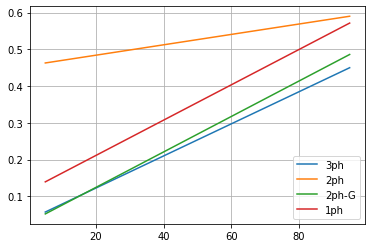

In [9]:
## Curvas Línea 632
loc3ph, mag3ph =lin_Regression(loc2, L632_dotcurves[0])
loc2ph, mag2ph =lin_Regression(loc2, L632_dotcurves[1])
loc2gph, mag2gph =lin_Regression(loc2, L632_dotcurves[2])
loc1ph, mag1ph =lin_Regression(locl, L632_dotcurves[-1])
Ch_curves_L632 = {"3-ph":[loc3ph, mag3ph],"2-ph":[loc2ph, mag2ph], "2-phG":[loc2gph, mag2gph], "1-ph":[loc1ph, mag1ph]}

plt.figure()
plt.plot(loc3ph, mag3ph)
plt.plot(loc2ph, mag2ph)
plt.plot(loc2gph, mag2gph)
plt.plot(loc1ph, mag1ph)
plt.legend(['3ph', '2ph', '2ph-G', '1ph'])
plt.grid()
plt.show

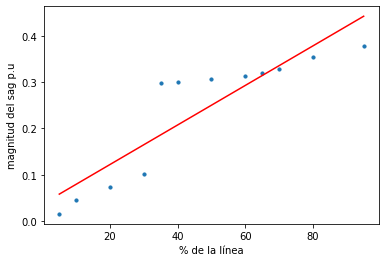

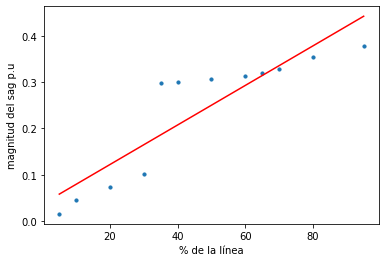

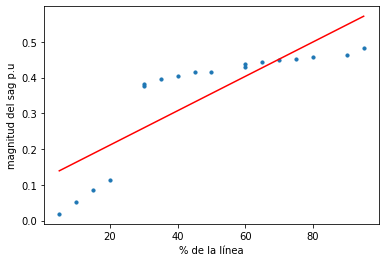

<function matplotlib.pyplot.show>

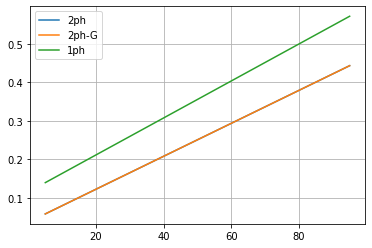

In [10]:
## Curvas Linea 645
loc2ph, mag2ph =lin_Regression(loc2, L645_dotcurves[2])
loc2gph, mag2gph =lin_Regression(loc2, L645_dotcurves[2])
loc1ph, mag1ph =lin_Regression(locl, L632_dotcurves[-1])
Ch_curves_L645 = {"2-ph":[loc2ph, mag2ph], "2-phG":[loc2gph, mag2gph], "1-ph":[loc1ph, mag1ph]}

plt.figure()
plt.plot(loc2ph, mag2ph)
plt.plot(loc2gph, mag2gph)
plt.plot(loc1ph, mag1ph)
plt.legend(['2ph', '2ph-G', '1ph'])
plt.grid()
plt.show

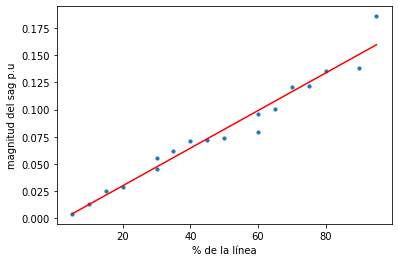

In [11]:
#Curva Línea 684
loc1ph, mag1ph =lin_Regression(locl, L684_dotcurves[-1])
Ch_curves_L684 = {"2-ph":[loc2ph, mag2ph], "2-phG":[loc2gph, mag2gph], "1-ph":[loc1ph, mag1ph]}

## Comparative graph of events with GD and without GD

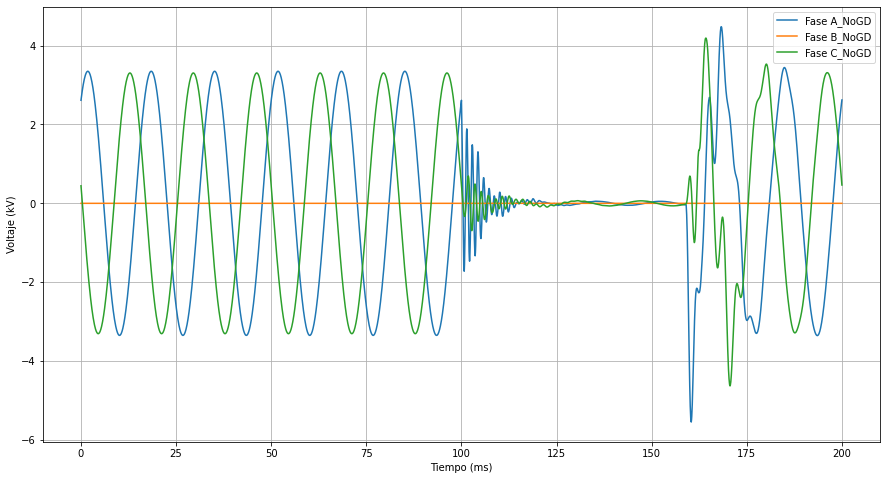

tipo de falla [2]


In [17]:
plt.figure(figsize=(15,8))
plt.plot(1000*signals_NOGD[0].get("time"), signals_NOGD[32].get("A"))
plt.plot(1000*signals_NOGD[0].get("time"), signals_NOGD[32].get("B"))
plt.plot(1000*signals_NOGD[0].get("time"), signals_NOGD[32].get("C"))
#plt.plot(1000*signals_GD[2].get("time"), signals_GD[205].get("A"))
#plt.plot(1000*signals_GD[2].get("time"), signals_GD[10].get("B"))
#plt.plot(1000*signals_GD[2].get("time"), signals_GD[10].get("C"))
plt.legend(["Fase A_NoGD", "Fase B_NoGD", "Fase C_NoGD"])#, "Fase A_GD", "Fase B_GD", "Fase C_GD"])
plt.xlabel("Tiempo (ms)")
plt.ylabel("Voltaje (kV)")
plt.grid()
plt.show()
#ph_1, ph_2, ph_2G, ph_3, noF = 0, 1, 2, 3, 4
print('tipo de falla',f_catNOGD[32])

## Distribution between training and test data

In [13]:
pos_inputs = np.arange(0,len(Total_id_files), 1)


Osc L645-646_80%_Falla 1ph_GD.cfg


In [14]:
def get_train_test(y_col, x_col, ratio):
    """ 
    This method transforms a dataframe into a train and test set, for this you need to specify:
    1. the ratio train : test (usually 0.7)
    2. the column with the Y_values
    """
    mask = np.random.rand(len(y_col)) < ratio
    Y_train = y_col[mask]
    Y_test = y_col[~mask]   
    X_train = x_col[mask]
    X_test = x_col[~mask]
    return X_train, Y_train, X_test, Y_test

X_train, Y_train, X_test, Y_test = get_train_test(Total_faults_ids, pos_inputs, 0.7) ## First model
XC_train, YC_train, XC_test, YC_test = get_train_test(Total_faults_types, Total_signals, 0.7) ## Conv Model 

def Table_Set(X_train, Y_train, X_test, Y_test):
    id_f = ['Fault Type', 'Train Set', 'Test Set', 'Total']
    faults = ['1Ph', '2Ph', '2Ph-to-G', '3Ph', 'None','Total']
    Num_train = [np.count_nonzero(Y_train == 0), np.count_nonzero(Y_train == 1), np.count_nonzero(Y_train == 2), np.count_nonzero(Y_train == 3), np.count_nonzero(Y_train == 4), len(Y_train)]
    Num_test = [np.count_nonzero(Y_test == 0), np.count_nonzero(Y_test == 1), np.count_nonzero(Y_test == 2), np.count_nonzero(Y_test == 3), np.count_nonzero(Y_test == 4), len(Y_test)]
    Total = [Num_train[0]+Num_test[0], Num_train[1]+Num_test[1], Num_train[2]+Num_test[2], Num_train[3]+Num_test[3], Num_train[4]+Num_test[4], Num_train[5]+Num_test[5]]
    data = [id_f] + list(zip(faults, Num_train, Num_test, Total))
    for i, d in enumerate(data):
        line = '|'.join(str(x).ljust(Total[3]) for x in d)
        print(line)
        if i == 0:
            print('-' * len(line))
        
Table_Set(X_train, Y_train, X_test, Y_test)

Fault Type                                      |Train Set                                       |Test Set                                        |Total                                           
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1Ph                                             |280                                             |118                                             |398                                             
2Ph                                             |48                                              |16                                              |64                                              
2Ph-to-G                                        |72                                              |40                                              |112                                             
3Ph                 

In [15]:
print(XC_train.shape)

(476,)


In [37]:
#print(type(X_train), type(XC_train))
#print(XC_test)
X_sig_Train = []
X_names_Test = []
X_sig_Test = []
for pos in range(len(X_train)):
    X_sig_Train.append(Total_signals[X_train[pos]])

for ind in range(len(X_test)):
    X_sig_Test.append(Total_signals[X_test[ind]])
    X_names_Test.append(Total_id_files[X_test[ind]])
print(len(X_sig_Train), type (X_sig_Train), len(X_sig_Test))
print(type(X_test), X_test.shape, type(YC_test))
print(X_sig_Test[15])
print(X_names_Test[15])
print(Y_test[15])
X_sig_Train = np.array(X_sig_Train)
X_sig_Test = np.array(X_sig_Test)

471 <class 'list'> 201
<class 'numpy.ndarray'> (201,) <class 'numpy.ndarray'>
{'A': array([2.618282, 2.669682, 2.719882, ..., 2.517882, 2.571782, 2.623882]), 'B': array([-3.299339, -3.259039, -3.217139, ..., -3.370639, -3.336639,
       -3.300039]), 'C': array([0.439164, 0.356464, 0.273564, ..., 0.618064, 0.537364, 0.456064]), 'time': array([0.00000000e+00, 6.66666667e-05, 1.33333333e-04, ...,
       1.99866667e-01, 1.99933333e-01, 2.00000000e-01])}
Osc L692-675_10%_Falla 1ph_NOGD.cfg
[0]


In [38]:
## Almacenamiento de eventos por tipo de falla para usuarios
def Get_UserTest_Folder(X_testset, Y_testset):
  List_3ph = []
  List_2ph = []
  List_2phG = [] 
  List_1ph = []
  List_none = []
  for j in range(len(Y_testset)):
    if Y_testset[j] == 0:
      List_1ph.append(X_testset[j])
    elif Y_testset[j] == 1:
      List_2ph.append(X_testset[j])
    elif Y_testset[j] == 2:
      List_2phG.append(X_testset[j])
    elif Y_testset[j] == 3:
      List_3ph.append(X_testset[j])
    elif Y_testset[j] == 4:
      List_none.append(X_testset[j])
  return List_3ph, List_2ph, List_2phG, List_1ph, List_none

L_3ph, L_2ph, L_2phG, L_1ph, L_n = Get_UserTest_Folder(X_sig_Test, Y_test)
print(len(L_1ph),len(L_2ph),len(L_2phG), len(L_3ph), len(L_n))


118 16 40 14 13


In [40]:
print('prueba',X_sig_Test.shape)
print('prueba 2', XC_test.shape)

prueba (201,)
prueba 2 (196,)


## Obtaining Discrete Wavelet Transform (DWT)

In [41]:
# Conversión a nivel de energía 5 - CORRER SOLO UNA VEZ
def DWT_Level_N(Xset):
    X_lev5 = copy.deepcopy(Xset)
    X_mat = []
    for x in X_lev5:
        for k, v in x.items():
            if k is not "time":
                coeffs = pywt.wavedec(v, 'bior4.4', level=5)
                cA, cD5, cD4, cD3, cD2, cD1 = coeffs
                levels = np.concatenate((cD5, cD4, cD3, cD2, cD1))
                x.update({k:levels})
        x.pop("time")
        m = np.array([x[i] for i in x.keys()])
        X_mat.append(m.T)
    return X_lev5, cA, X_mat

XTrain_5lev, _, X_mat_Train = DWT_Level_N(X_sig_Train)
XTest_5lev, _, X_mat_Test = DWT_Level_N(X_sig_Test)
print(len(XTrain_5lev), X_mat_Train[0].shape, len(X_mat_Train))
print(len(XTrain_5lev[10].get("C")))
print(len(X_mat_Train), len(X_mat_Train[0]))

471 (2943, 3) 471
2943
471 2943


<class 'list'>


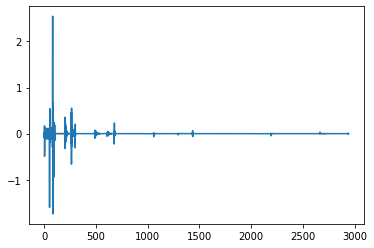

In [47]:
print(type(X_mat_Train))
plt.figure()
plt.plot(XTrain_5lev[10].get("A"))

## Final Stage: Outputs and results of data handling

In [43]:
## EXPORT .MAT FILES and other formats 
import pickle
Comtrade_signals_dict = {"NOGD_signals": signals_NOGD, "GD_signals": signals_GD}
Training_Test_set_dict = {"X_train": X_mat_Train, "Y_train": Y_train, "X_test": X_mat_Test, "Y_test":Y_test}
#Training_Test_set_dict = {"X_train": X_mat_Train, "Y_train": YC_train, "X_test": X_mat_Test, "Y_test":YC_test}
Test_set_dict = {'X_test_filenames': X_names_Test ,"X_test":X_sig_Test, "Y_test":Y_test}
Fault_cats_dict = {"3ph-faults": L_3ph, "2ph-faults": L_2ph, "2phG-faults": L_2phG, "1ph-faults": L_1ph, "No-faults": L_n}
Curves_Lines_NOGD_dict = {'L692_NOGD':Ch_curves_L692, 'L632_NOGD':Ch_curves_L632, 'L645_NOGD':Ch_curves_L645, 'L684_NOGD':Ch_curves_L684}
Curves_Lines_GD_dict = {'L692_GD':Ch_curves_L692, 'L632_GD':Ch_curves_L632, 'L645_GD':Ch_curves_L645, 'L684_GD':Ch_curves_L684}
sio.savemat("Training&Test_set.mat", Training_Test_set_dict)

pickle_out = open("Comtrade_dict.pickle","wb")
pickle.dump(Comtrade_signals_dict, pickle_out)
pickle_out.close()

pickle_out2 = open("Test_dict.pickle","wb")
pickle.dump(Test_set_dict, pickle_out2)
pickle_out.close()

pickle_out3 = open("Fault_Categories.pickle","wb")
pickle.dump(Fault_cats_dict, pickle_out3)
pickle_out.close()

pickle_out4 = open("Curves_Lines_NOGD.pickle","wb")
pickle.dump(Curves_Lines_NOGD_dict, pickle_out4)
pickle_out.close()

pickle_out5 = open("Curves_Lines_GD.pickle","wb")
pickle.dump(Curves_Lines_GD_dict, pickle_out5)
pickle_out.close()

pickle_out6 = open("Curves_Lines_prueba.pickle","wb")
pickle.dump(Curves_Lines_NOGD_dict, pickle_out6)
pickle_out.close()


In [19]:
prueba_set_dict = {"X_train": X_mat_Train}
sio.savemat("prueba_set.mat", prueba_set_dict)


In [24]:
prueba = sio.loadmat('/content/prueba_set.mat')
X_trainset_v2 = prueba.get("X_train")
print('len', X_trainset_v2[0])

len [[-9.40675121e-02  0.00000000e+00  2.71921013e-01]
 [ 2.17965630e-02  0.00000000e+00 -2.66677077e-02]
 [-7.75338682e-02  0.00000000e+00  1.31479685e-01]
 ...
 [-1.15749501e-02  0.00000000e+00  1.84105409e-02]
 [ 3.63872784e-03  0.00000000e+00 -5.48243703e-03]
 [-1.81127733e-04  0.00000000e+00 -1.18272844e-04]]
